# Plot Paper Figures


In [1]:
%cd ../

/Users/jesteves/Documents/GitHub/galaxyFormation


In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('./scripts')
from file_loc import FileLocs
# from compute_fractions import *
from utils import check_non_valid_number, gaussian_kde

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<AxesSubplot:>

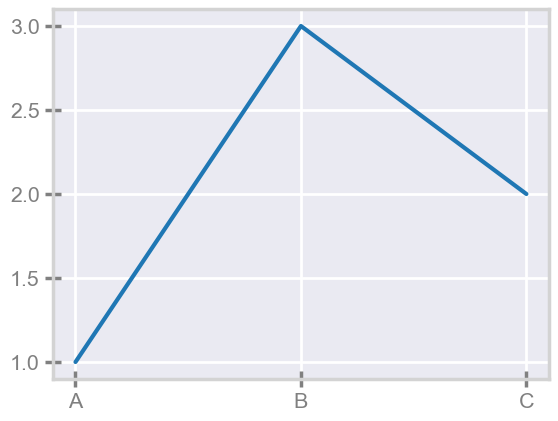

In [3]:
import seaborn as sns
sns.set_context('poster', font_scale=0.7)

rc_params = {'axes.edgecolor': 'lightgray',
             'ytick.left': True,'xtick.bottom': True,
             'ytick.direction':'inout', 'xtick.direction':'inout',
             'ytick.color':'gray','xtick.color':'gray'}

sns.set_style("darkgrid",rc=rc_params)
sns.lineplot(x=["A", "B", "C"], y=[1, 3, 2])


In [4]:
def save_figures(fig,fname,is_tight=False):
    if is_tight: fig.tight_layout()
    fig.savefig(fname,transparent=False,facecolor='w',dpi=120)

## Load Data

In [5]:
fl = FileLocs(dataset='sdss')
gal0 = fl.load_catalogs('galaxy/main')

mask  = (gal0['VLOS_MASK']).astype(bool)
mask &= gal0['VOLUME_LIM_MASK'].astype(bool)

gal = gal0[mask].copy()
cat = fl.load_catalogs('cluster/frac_vl')

Loading Catalog: ./data/catalogs/SDSS/groups_deCarvalho2017_5xR200m_galaxies_johnnyheq_pp.csv
Loading Catalog: ./data/catalogs/SDSS/groupCatalog_Yang_deCarvalho2017_frac_vl.csv


### Setting Variables

In [6]:
gid = np.array(gal['Yang'])

zgal = np.array(gal['z'])
Mr   = np.array(gal['Mr'])

log_smass = np.array(gal['mass'])
smass = 10**log_smass
redshift = np.array(gal['redshift'])

rn = np.array(gal['Rm'])
vn = np.array(gal['vlosn'])
morph_type = np.array(gal['TType'])
ssfr = np.array(gal['ssfr'])

# sfr classification
sf   = np.array(gal['SF']).astype(int)
qf   = (1-sf).astype(int)

# morphological classification
sp   = np.where(gal['TType'] > 0, 1, 0).astype(int)
ell  = np.where(gal['TType'] <=0, 1, 0).astype(int)
s0   = check_non_valid_number(gal['Pbulge'])
s0[np.isnan(s0)] = 0.

# b/t definition
bt = np.array(gal['BT'])
bt2 = np.where(bt>=0.5,1.,bt)
bt2 = np.where(bt<0.5,0.,bt2)

# dynamical probabilities
Pi   = np.array(gal['p_infall'])
Po   = np.array(gal['p_orbital'])
Pn   = np.array(gal['p_interlopers'])
Pf = np.where(rn>2,Pn,0.)

m200 = np.array(gal['M200c'])

# mask
bt_mask = bt>=0.

# Data - SDSS

### Figure 1

In [7]:
figure1 = 'figures/fig1.png'

In [8]:
label_fsize = 22

label_z = r'z'
label_mr = r'M$_{r}$ [mag]'
label_smass = r'M$_{\star}$ [M$_{\odot}$]'
label_log_smass = r'Log(M$_{\star}$/M$_{\odot}$)'

label_sdss = 'SDSS DR7 MPA-JPU'

In [9]:
Mr_thrshold = -20.16

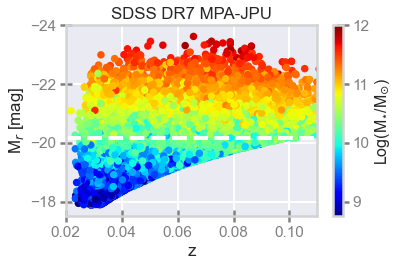

In [11]:
fig = plt.figure(figsize=(6,4))
plt.scatter(zgal,Mr,c=np.log10(smass),vmin=8.75,vmax=12.,s=30,cmap='jet')
# plt.plot(zbins2, ylow, ls='--',lw=4,color='w')
plt.axhline(Mr_thrshold,ls='--',lw=4,color='w')
plt.ylim(-18.5+1,-24.)
plt.xlim(0.02, 0.11)

plt.colorbar().set_label(label_log_smass,fontsize=16)
plt.xlabel(label_z)
plt.ylabel(label_mr)
plt.title(label_sdss)
save_figures(fig,figure1,is_tight=True)

# Dynamical Classification

In [11]:
figure2 = 'figures/fig2.png'

Dynamical Classification Labels: ['Orbital', 'Infall', 'Interlopers', 'Field']
Color pallete


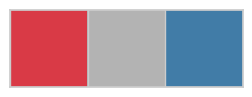

In [15]:
list_labels_dynamics = ['Orbital', 'Infall', 'Interlopers','Field']

colors_dynamics = sns.diverging_palette(10, 240, n=3)
colors_dynamics[1] = sns.color_palette("Set2")[7]
cmap_dynamics = sns.diverging_palette(10, 240, n=9, as_cmap=True)
cmap_dynamics_r= sns.diverging_palette(240, 10, n=9, as_cmap=True)

print(f'Dynamical Classification Labels: {list_labels_dynamics}')
print('Color pallete')
sns.palplot(colors_dynamics)

In [13]:
tags = np.argmax(np.vstack([Po,Pi,Pn]).T,axis=1)
probs = np.max(np.vstack([Po,Pi,Pn]).T,axis=1)
probs.size

97955

In [14]:
label_rnorm = r' R [R$\rm _{200m}$]'
label_vnorm = r'$\rm v_{los}/ v_{circ} $'

In [15]:
# f, axs = plt.subplots(1,1,figsize=(8,6))

def plot_phase_space(x,v,tags,probs,axs=None,is_colorbar=False,
                     scale=50,cmap=cmap_dynamics,**kwargs):    
    prob_scale = scale*probs+0.
    p = axs.scatter(x,v,c=tags,cmap=cmap,s=prob_scale,**kwargs)
    axs.set_xlabel(label_rnorm,fontsize=20)
    axs.set_ylabel(label_vnorm,fontsize=24)
    if is_colorbar:
        return p
    
def plot_histogram():
    binwidth = 0.1
    xymax = max(np.max(np.abs(rn)), np.max(np.abs(vn)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(-lim, lim + binwidth, binwidth)

    ax_histx.tick_params(axis="x", labelbottom=False)
    _ = ax_histx.hist(rn, bins=bins, weights=Po,label=list_labels_dynamics[0],
                      color=colors_dynamics[0], histtype='stepfilled',
                      lw=6,alpha=0.5)

    _ = ax_histx.hist(rn, bins=bins, weights=Pn,label=list_labels_dynamics[2],
                      color=colors_dynamics[2], histtype='stepfilled',
                      lw=6,alpha=0.5)

    _ = ax_histx.hist(rn, bins=bins, weights=Pi,label=list_labels_dynamics[1],
                      color='lightgray', histtype='stepfilled',
                      lw=3,alpha=0.5,edgecolor='gray')

    ax_histx.legend(bbox_to_anchor=(0.1, 1.1, 0.8, .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., shadow=False)
    ax_histx.tick_params(bottom = False)

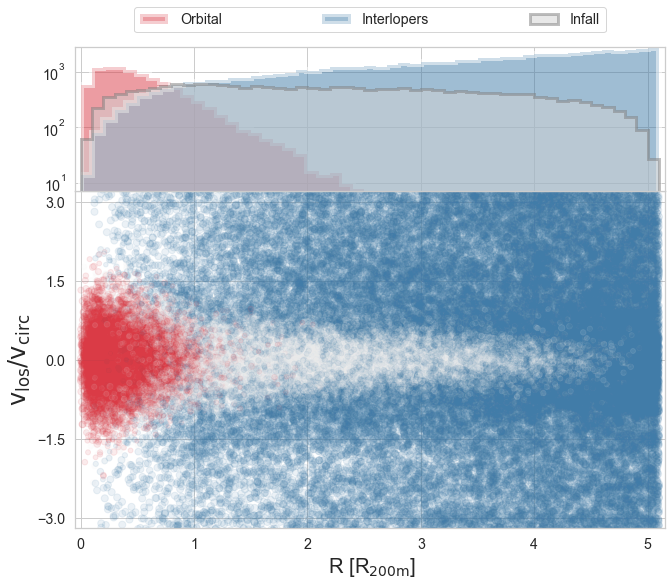

In [30]:
# start with a square Figure
fig = plt.figure(figsize=(1.2*8, 1.2*7.))

# Add a gridspec with two rows and one columns and a ratio of 2.5 to 7 between
gs = fig.add_gridspec(2, 1,  height_ratios=(3., 7),
                      wspace=0.0, hspace=0.)

# defining sub-axes
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)

plot_phase_space(rn,vn,tags,probs,axs=ax,scale=50,alpha=0.1)
plot_histogram()

ax.set_xlim(-0.05,5.15)
ax.set_ylim(-3.2,3.2)
ax_histx.set_xlim(-0.05,5.15)
ax_histx.set_ylim(7,)
ax_histx.set_yscale('log')

ax.set_yticks(np.array([-3.,-1.5,0.,1.5,3.]))
ax_histx.set_yticks(np.array([10,100,1000]))
save_figures(fig,figure2,is_tight=True)

In [10]:
figure3 = 'figures/fig3.png'
figureX = 'figures/figX.png'

In [11]:
label1 = ['Cluster', 'Infall', 'Interlopers']
label2 = ['Orbital-Infall', 'Orbital-Interlopers', 'Infall-Interlopers', 'Infall-Field']
xlabels = {'cross_time':r't$_{cross}$ [Gyr]','smass':r'Log($M_\star/M_{\odot}$)','radii':r'R/R$_{200}$'}


In [12]:
fmts = [['o','-',1.],['s','--',0.6]]

In [13]:
sns.set_style("whitegrid")
sns.set_context("notebook",font_scale=1.3)

In [16]:
colors_dynamics2 = colors_dynamics.copy()
colors_dynamics2[1] = colors_dynamics[2]
colors_dynamics2[2] = colors_dynamics[1]

In [17]:
dataset= 'TNG'
key    = 'magTH'
name   = 'quenching'
xlabel = 'radii'
save   = True

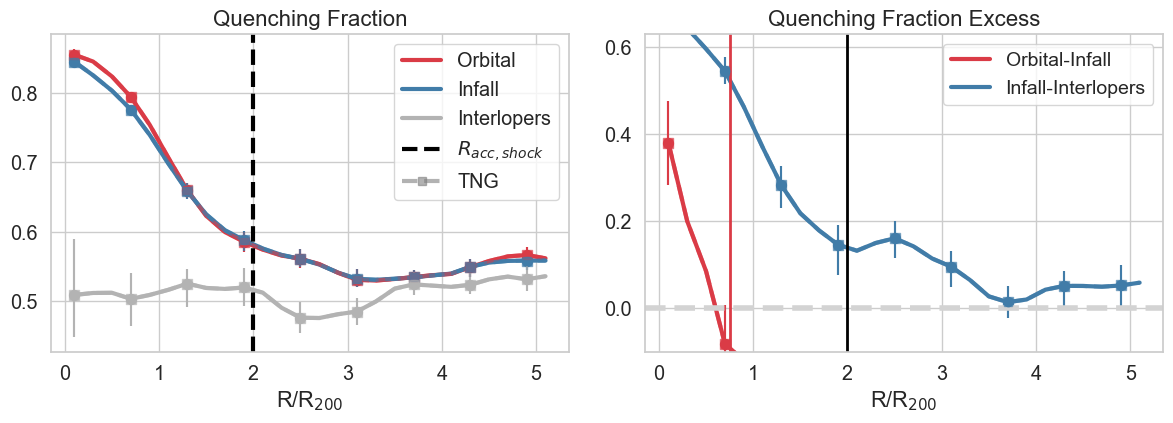

In [79]:
fig = plt.figure(figsize=(12,4.5))
for kk,dataset in enumerate(['SDSS','TNG']):
#     fname = fl.root+f'{dataset}/outputs/{key}/{name}_{xlabel}.npy'
    fname = './data/outputs/sdss/HardCut/bin_4_quenching_radii.npy'
    x = np.loadtxt(fname).T
    plt.subplot(1, 2, 1)
    for i in range(3):
        ii = 4*i + 1
        li = list_labels_dynamics[i]
        if kk==1: 
            li = '_'
            if i==0:
                plt.errorbar([None,None],[None,None],alpha=fmts[kk][2],lw=3,
                             color='gray',ls=fmts[kk][1], fmt=fmts[kk][0],label='TNG')
                
        plt.plot(x[0], x[ii],
                 ls=fmts[kk][1],alpha=fmts[kk][2], lw=3,
                 label=li, color=colors_dynamics2[i])
        
        plt.scatter(x[0][::3], x[ii][::3], s=50,
                         marker=fmts[kk][0], alpha=fmts[kk][2],
                         color=colors_dynamics2[i])
        
        plt.errorbar(x[0][::3], x[ii][::3], yerr=np.vstack([x[ii+1][::3],x[ii+2][::3]]), ls=None,
                     fmt=fmts[kk][0], alpha=fmts[kk][2],
                     color=colors_dynamics2[i])
    
    if kk==1:
        plt.axvline(2.,ls='--',lw=3,color='k',label=r'$R_{acc,shock}$')
    # plt.text(2.07, 0.52, 'Field', size=24, color='k')

    plt.legend()
    plt.xlabel(xlabels[xlabel])
    #plt.xlabel(r'Log($M_\star/M_{\odot}$)',fontsize=16)
    plt.title('%s Fraction'%name.capitalize(),fontsize=16)

    plt.subplot(1, 2, 2)
    jj=0
    for i in np.array([0,2]):
        ii = (4*i + 1)+16
        li = label2[i]
        if kk==1: li = '_'
        plt.plot(x[0], x[ii],
                 ls=fmts[kk][1],alpha=fmts[kk][2], lw=3,
                 label=li, color=colors_dynamics2[jj])
        
        plt.scatter(x[0][::3], x[ii][::3], s=50,
                         marker=fmts[kk][0], alpha=fmts[kk][2],
                         color=colors_dynamics2[jj])
        
        plt.errorbar(x[0][::3], x[ii][::3], yerr=np.vstack([x[ii+1][::3],x[ii+2][::3]]), ls=None,
                         fmt=fmts[kk][0], alpha=fmts[kk][2],
                        color=colors_dynamics2[jj])
        
        plt.ylim(-0.1,0.63)
        jj += 1
plt.axvline(0.75,color=colors_dynamics2[0],lw=2,ls='-')
plt.axvline(2.,ls='-',lw=2,color='k')
plt.axhline(0.,ls='--',lw=4,color='lightgray')
plt.xlabel(xlabels[xlabel])

plt.legend(fontsize=14)
plt.title('%s Fraction Excess'%name.capitalize(),fontsize=16)

del x
if save:
    save_figures(fig,figure3,is_tight=True)

In [55]:
key    = 'volumeLimited'
xlabel = 'smass'

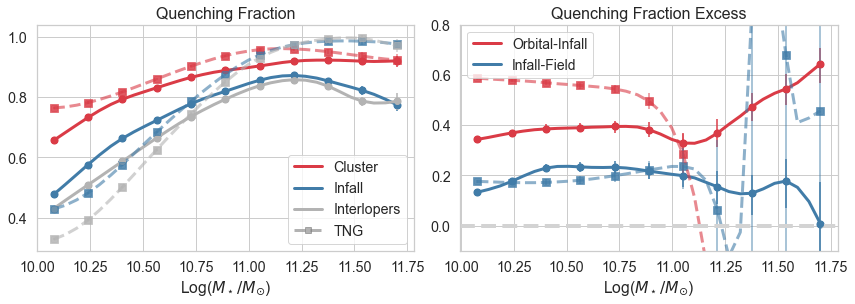

In [65]:
fig = plt.figure(figsize=(12,4.5))
for kk,dataset in enumerate(['SDSS','TNG']):
    fname = fl.root+f'{dataset}/outputs/{key}/{name}_{xlabel}.npy'
    x = np.loadtxt(fname).T
    plt.subplot(1, 2, 1)
    for i in range(3):
        ii = 4*i + 1
        li = label1[i]
        if kk==1: 
            li = '_'
            if i==0:
                plt.errorbar([None,None],[None,None],alpha=fmts[kk][2],lw=3,
                             color='gray',ls=fmts[kk][1], fmt=fmts[kk][0],label='TNG')
        w, = np.where(x[0]>10.05)  
        plt.plot(x[0][w], x[ii][w],
                 ls=fmts[kk][1],alpha=fmts[kk][2], lw=3,
                 label=li, color=colors_dynamics2[i])
        
        plt.scatter(x[0][w][::3], x[ii][w][::3], s=50,
                         marker=fmts[kk][0], alpha=fmts[kk][2],
                         color=colors_dynamics2[i])
        
        plt.errorbar(x[0][w][::3], x[ii][w][::3], yerr=np.vstack([x[ii+1][w][::3],x[ii+2][w][::3]]), ls=None,
                     fmt=fmts[kk][0], alpha=fmts[kk][2],
                     color=colors_dynamics2[i])
    
    # plt.text(2.07, 0.52, 'Field', size=24, color='k')

    plt.legend()
    plt.xlabel(xlabels[xlabel])
    #plt.xlabel(r'Log($M_\star/M_{\odot}$)',fontsize=16)
    plt.title('%s Fraction'%name.capitalize(),fontsize=16)

    plt.subplot(1, 2, 2)
    jj=0
    for i in np.array([0,3]):
        ii = (4*i + 1)+16
        li = label2[i]
        if kk==1: li = '_'
        plt.plot(x[0][w], x[ii][w],
                 ls=fmts[kk][1],alpha=fmts[kk][2], lw=3,
                 label=li, color=colors_dynamics2[jj])
        
        plt.scatter(x[0][w][::3], x[ii][w][::3], s=50,
                         marker=fmts[kk][0], alpha=fmts[kk][2],
                         color=colors_dynamics2[jj])
        
        plt.errorbar(x[0][w][::3], x[ii][w][::3], yerr=np.vstack([x[ii+1][w][::3],x[ii+2][w][::3]]), ls=None,
                     fmt=fmts[kk][0], alpha=fmts[kk][2],
                     color=colors_dynamics2[jj])
        jj += 1

plt.ylim(-0.1,0.8)
# plt.axvline(2.,ls='--',lw=3,color='k')
plt.axhline(0.,ls='--',lw=4,color='lightgray')
plt.xlabel(xlabels[xlabel])

plt.legend(fontsize=14)
plt.title('%s Fraction Excess'%name.capitalize(),fontsize=16)

del x
if save:
    save_figures(fig,figureX,is_tight=True)

## The Infall Region: Quenching

In [57]:
figure4 = 'figures/fig4.png'

In [58]:
label_sfr = r'SFR [$ M_{\star} / yr$]'
label_ssfr = r'sSFR [yr$^{-1}$]'

In [59]:
def get_kde(xy,weights=None):
    pdf = gaussian_kde(xy, weights=weights)
    pdf.set_bandwidth(bw_method=pdf.factor / 1.)  # kde bandwidth
    zz2 = pdf((np.ravel(xx), np.ravel(yy)))
    zz2 = np.reshape(zz2, xx.shape)
    return zz2

def get_density(x1,x2,x3):
    f = get_kde(np.vstack([x1,x2]),weights=x3)
    return f.T

In [60]:
# grid
xmin, xmax = 9., 11.75
ymin, ymax = -13.25, -9.
x = np.linspace(xmin, xmax, 100)  # kde resolution
y = np.linspace(ymin, ymax, 100)  # kde resolution
xx, yy = np.meshgrid(x, y)

nz = ssfr>-20
pdf_o = get_density(log_smass[nz],ssfr[nz],Po[nz])
pdf_i = get_density(log_smass[nz],ssfr[nz],Pi[nz])
pdf_f = get_density(log_smass[nz],ssfr[nz],Pf[nz])

In [67]:
def sSFRmass(image,xth=0.0,ax=None,title=None,xlabel=label_log_smass):
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

#     cfset = ax.contourf(xx, yy, f, cmap='jet')
    ax.imshow(np.rot90(image), cmap='jet', extent=[xmin, xmax, ymin, ymax], aspect=0.5)
    cset = ax.contour(xx, yy, image.T, 4, colors='k')
    ax.clabel(cset, inline=1, fontsize=10, inline_spacing=0)
    ax.set_xlabel(xlabel)
    ax.axhline(-11.0,ls='--',lw=3,color='white')
    if title is not None:
        ax.set_title(title,fontsize=40)

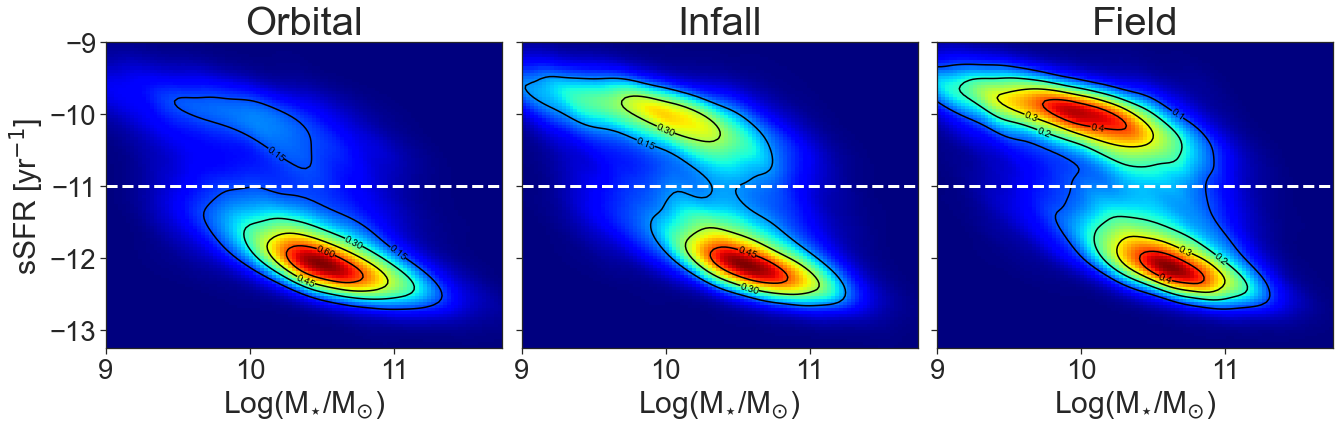

In [68]:
sns.set_style("ticks")
sns.set_context('notebook',font_scale=2.5)
fig, axis = plt.subplots(1, 3, figsize=(3*6+4,6.2),sharey='row')
fig.subplots_adjust(wspace=0.05,hspace=0.05)

sSFRmass(pdf_o,ax=axis[0],title=list_labels_dynamics[0])
sSFRmass(pdf_i,ax=axis[1],title=list_labels_dynamics[1])
sSFRmass(pdf_f,ax=axis[2],title=list_labels_dynamics[3])

axis[0].set_ylabel(label_ssfr)
save_figures(fig,figure4,is_tight=False)

## Morphology

In [50]:
figure5 = 'figures/fig5.png'
figure6 = 'figures/fig6.png'

In [51]:
sns.set_style("whitegrid")
sns.set_context("talk",font_scale=1.0)

In [52]:
reds = sns.diverging_palette(10, 240, n=12)[:2]
reds[1] = sns.diverging_palette(10, 240, n=12)[4]
# reds = np.flip(reds)

blus = sns.diverging_palette(10, 240, n=12)[-2:]
blus[1] = sns.diverging_palette(10, 240, n=12)[-5]

In [53]:
import pandas as pd
def plot_enviroment3(cat1,mytpe1,mytpe2,title='SDSS',outname=None):
    y1,x1 = get_variables(cat1,mytpe1)
    y2,x2 = get_variables(cat1,mytpe2)
    
    y = np.hstack([y1,y2])
    x = np.hstack([x1,x2])
    
    #labels = np.full((x.size),mytpe2)
    labels = np.full((x.size),'Quenching')
    labels[x1.size:] = 'Ell+S0'
    
    res = pd.DataFrame({'Fraction':y,'Environment':x,'label':labels})
    
    plt.clf()
    g = sns.catplot(x='Environment', y="Fraction", kind="box", hue="label", 
                    data=res,estimator=np.median, palette=reds, legend=False)
    plt.legend(bbox_to_anchor=(0., 1.0, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., shadow=False)
    plt.title(title,fontsize=18)
    if outname is not None:
        save_figures(plt,outname,is_tight=True)

def get_variables(cat0,mytpe):
    orbital = np.array(cat0['fo_%s'%(mytpe)])
    infall = np.array(cat0['fi_%s'%(mytpe)])
    interloper = np.array(cat0['ff_%s'%(mytpe)])
    
    x1label = np.full((orbital.size),'Orbital')
    x2label = np.full((orbital.size),'Infall')
    x3label = np.full((orbital.size),'Field')
    
    y = np.hstack([orbital,infall,interloper])
    x = np.hstack([x1label,x2label,x3label])
    return y,x


<Figure size 432x288 with 0 Axes>

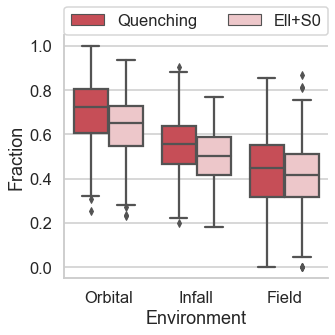

In [54]:
plot_enviroment3(cat,'quenching','elliptical',
                 title=None,outname=figure5)

In [55]:
Psp   = np.where(gal['TType'] > 0, 1, 0).astype(int)

In [56]:
# grid
xmin, xmax = 0., 3.
ymin, ymax = -13.25, -8.75
x = np.linspace(xmin, xmax, 120)  # kde resolution
y = np.linspace(ymin, ymax, 100)  # kde resolution
xx, yy = np.meshgrid(x, y)

nz = ssfr>-20
pdfR_o = get_density(rn[nz],ssfr[nz],Po[nz]*Psp[nz])
pdfR_i = get_density(rn[nz],ssfr[nz],Pi[nz]*Psp[nz])
pdfR_n = get_density(rn[nz],ssfr[nz],Pn[nz]*Psp[nz])
pdfR_f = get_density(rn[nz],ssfr[nz],Pf[nz]*Psp[nz])
pdfR_oi = get_density(rn[nz],ssfr[nz],(Pi[nz]+Po[nz])*Psp[nz])

In [57]:
def sSFRmass(image,xth=0.0,ax=None,title=None,xlabel=label_log_smass):
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

#     cfset = ax.contourf(xx, yy, f, cmap='jet')
    #ax.imshow(np.rot90(image), cmap='jet', extent=[xmin, xmax, ymin, ymax], aspect=0.5)
    im = ax.scatter(xx.flatten(),yy.flatten(), s=100,c=image.T.flatten(),cmap='jet')
    cset = ax.contour(xx, yy, image.T, 4, colors='k')
    ax.clabel(cset, inline=1, fontsize=10, inline_spacing=0)
    ax.set_xlabel(xlabel)
    ax.axhline(-11.0,ls='--',lw=3,color='white')
    if title is not None:
        ax.set_title(title,fontsize=24)

<ipython-input-4-0837a42ce3b7>:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if is_tight: fig.tight_layout()


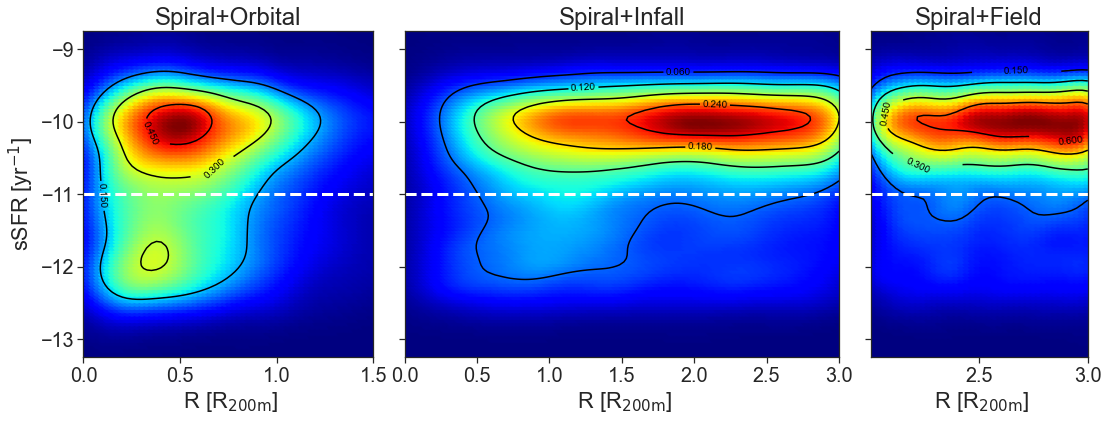

In [58]:
sns.set_style("ticks")
sns.set_context('notebook',font_scale=1.8)

# fig, axis = plt.subplots(1, 3, figsize=(3*6,6.2), sharey='row')
fig = plt.figure(figsize=(18,6.))
# Add a gridspec with two rows and one columns and a ratio of 2.5 to 7 between
gs = fig.add_gridspec(1, 3,  width_ratios=(2., 3, 1.5),
                      wspace=0.1, hspace=0.1)

# defining sub-axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1],sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2],sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

sSFRmass(pdfR_o,ax=ax1,title='Spiral+'+list_labels_dynamics[0],xlabel=label_rnorm)
sSFRmass(pdfR_i,ax=ax2,title='Spiral+'+list_labels_dynamics[1],xlabel=label_rnorm)
sSFRmass(pdfR_f,ax=ax3,title='Spiral+'+list_labels_dynamics[3],xlabel=label_rnorm)
ax1.set_xlim(0,1.5)
ax3.set_xlim(2.,3.)

ax1.set_xticks(np.arange(0.,1.5+0.5,0.5))
ax2.set_xticks(np.arange(0.,3+0.5,0.5))
ax3.set_xticks(np.array([2.5,3.]))
ax1.set_ylabel(label_ssfr)
save_figures(fig,figure6,is_tight=True)

## Galaxy River Flow

In [59]:
sns.set_context('talk', font_scale=0.9)
sns.set_style("darkgrid")

In [60]:
from sklearn.neighbors import KernelDensity

xmin, xmax = 0, 3.
ymin, ymax = -3.,3.
x = np.linspace(xmin, xmax, 300)  # kde resolution
y = np.linspace(ymin, ymax, 600)  # kde resolution
xx, yy = np.meshgrid(x, y)

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x)
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid)
    return np.exp(log_pdf)

xx_lin = np.ravel(xx)
yy_lin = np.ravel(yy)
xy_grid = np.vstack([xx_lin, yy_lin]).T

def get_density2(r,v,mask=None,bw=0.2, **kwargs):
    #xy_grid = np.vstack([r,v]).T
    xy = np.vstack([r,v]).T
    if mask is not None:
        xy = np.vstack([r[mask],v[mask]]).T
    pdf = kde_sklearn(xy, xy_grid, bandwidth=bw, **kwargs)
    return pdf

In [61]:
Nquenched = np.sum(qf)
Nall = qf.size
ones = np.ones_like(qf)

Pdf_a = get_density2(rn,vn,bw=0.2, kernel='tophat')
Pdf_q = get_density2(rn,vn,mask=qf.astype(bool), bw=0.2, kernel='tophat')

# generate probs
# probs is the quenching probability
probs = Nquenched*Pdf_q/(Nall*Pdf_a)

<ipython-input-61-a51aa9cf1bb3>:10: RuntimeWarning: invalid value encountered in true_divide
  probs = Nquenched*Pdf_q/(Nall*Pdf_a)


In [62]:
qf_field = 0.42
probs2 = (probs-qf_field)/(1-qf_field)

In [63]:
th = 0.005
plot_density = Pdf_a/np.max(Pdf_a)
plot_density = np.where(plot_density<th,0.,plot_density)

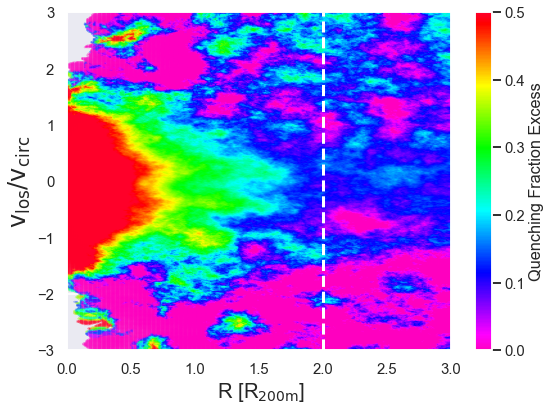

In [64]:
f, axs = plt.subplots(1,1,figsize=(8,6))
p = plot_phase_space(xx_lin,yy_lin,probs2,plot_density,axs=axs,scale=10,is_colorbar=True,
                     alpha=1., vmin=0., vmax=0.5,cmap='gist_rainbow_r')
axs.set_ylim(-3.,3.)
axs.set_xlim(0.,3.)
axs.axvline(2.,ls='--',lw=3,color='w')
f.colorbar(p,ax=axs).set_label('Quenching Fraction Excess')
save_figures(f,figure6,is_tight=True)

In [73]:
Nqsp = np.sum(qf*sp)
Nsp = np.sum(sp)
Pdf_sp = get_density2(rn,vn,mask=(sp).astype(bool), bw=0.3, kernel='tophat')
Pdf_qsp = get_density2(rn,vn,mask=(qf*sp).astype(bool), bw=0.3, kernel='tophat')

# generate probs
# probs is the quenching probability
probs3 = Nqsp*Pdf_qsp/(Nsp*Pdf_sp)

In [74]:
qf_sp = np.median(probs3[(xx_lin>2.75)&(yy_lin>2.5)])
qc_sp = np.median(probs3[(xx_lin<0.25)&(np.abs(yy_lin)<0.5)])

probs32 = (probs3-qf_sp)/(1-qf_sp)
print(f'field: {qf_sp}')
print(f'Cluster: {qc_sp}')

field: 0.20000000000000093
Cluster: 0.45959595959595845


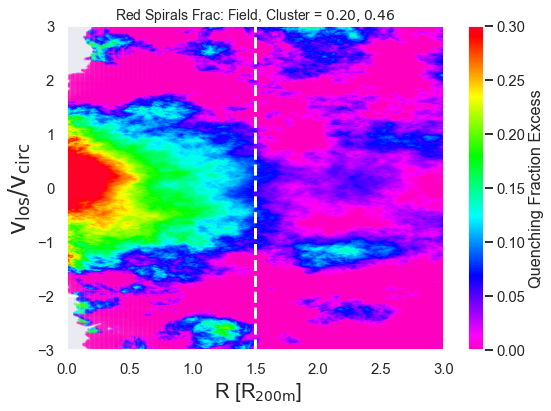

In [75]:
f, axs = plt.subplots(1,1,figsize=(8,6))
p = plot_phase_space(xx_lin,yy_lin,probs32,plot_density,axs=axs,scale=10,is_colorbar=True,
                     alpha=1., vmin=0., vmax=0.3,cmap='gist_rainbow_r')
axs.set_ylim(-3.,3.)
axs.set_xlim(0.,3.)
axs.axvline(1.5,ls='--',lw=3,color='w')
f.colorbar(p,ax=axs).set_label('Quenching Fraction Excess')
plt.title('Red Spirals Frac: Field, Cluster = $%.2f, %.2f$'%(qf_sp, qc_sp),fontsize=14)
save_figures(f,figure6,is_tight=True)

In [68]:
# s0 = gal['Pbulge']
s0 = (gal['TType']<=0.)&(gal['TType']>=-3) #np.where(sp,0.,1.)
# s0 = np.where(s0>0.5,1.,0.)
# s0 = s0[i]
isnan = ~np.isnan(s0)

In [69]:
Nqs0 = np.sum(qf[isnan]*s0[isnan])
Ns0 = np.sum(s0[isnan])
Pdf_s0 = get_density2(rn[isnan],vn[isnan],mask=(s0[isnan]).astype(bool), bw=0.3, kernel='tophat')
Pdf_qs0 = get_density2(rn[isnan],vn[isnan],mask=(qf[isnan]*s0[isnan]).astype(bool), bw=0.3, kernel='tophat')

# generate probs
# probs is the quenching probability
probs3 = Nqs0*Pdf_qs0/(Ns0*Pdf_s0)

<ipython-input-69-62d1d9ebb439>:8: RuntimeWarning: invalid value encountered in true_divide
  probs3 = Nqs0*Pdf_qs0/(Ns0*Pdf_s0)


In [70]:
qf_s0 = np.median(probs3[(xx_lin>2.75)&(yy_lin>2.5)])
qc_s0 = np.median(probs3[(xx_lin<0.25)&(np.abs(yy_lin)<0.5)])

probs32 = (probs3-qf_s0)/(1-qf_s0)
print(f'field: {qf_s0}')
print(f'Cluster: {qc_s0}')

field: 0.8390719450041488
Cluster: 0.9433799367555189


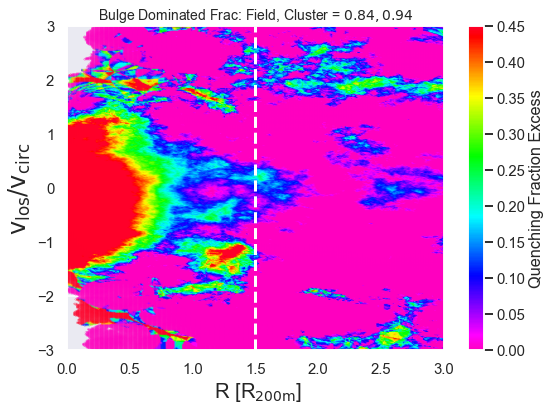

In [71]:
f, axs = plt.subplots(1,1,figsize=(8,6))
p = plot_phase_space(xx_lin,yy_lin,probs32,plot_density,axs=axs,scale=10,is_colorbar=True,
                     alpha=1., vmin=0.0, vmax=0.45,cmap='gist_rainbow_r')
axs.set_ylim(-3.,3.)
axs.set_xlim(0.,3.)
axs.axvline(1.5,ls='--',lw=3,color='w')
f.colorbar(p,ax=axs).set_label('Quenching Fraction Excess')
plt.title('Bulge Dominated Frac: Field, Cluster = $%.2f, %.2f$'%(qf_s0, qc_s0),fontsize=14)
save_figures(f,figure6,is_tight=True)

# Illustris TNG300

In [76]:
figure7 = 'figures/fig7.png'

In [77]:
fl = FileLocs(dataset='tng')
cat2 = fl.load_catalogs('cluster/frac_th')

fl = FileLocs(dataset='sdss')
cat1 = fl.load_catalogs('cluster/frac_th')

Loading Catalog: ./data/catalogs/TNG/TNG300-1_GalEvol_z0p10_frac_th.csv
Loading Catalog: ./data/catalogs/SDSS/groupCatalog_Yang_deCarvalho2017_frac_th.csv


In [78]:
cat2

Yang,M200c,R200c,M200m,R200m,fo_quenching,fo_quenching_err,fi_quenching,fi_quenching_err,fn_quenching,fn_quenching_err,ff_quenching,ff_quenching_err,qf1_quenching,qf1_quenching_err,qf2_quenching,qf2_quenching_err,qf3_quenching,qf3_quenching_err,qf4_quenching,qf4_quenching_err,fo_sf,fo_sf_err,fi_sf,fi_sf_err,fn_sf,fn_sf_err,ff_sf,ff_sf_err,qf1_sf,qf1_sf_err,qf2_sf,qf2_sf_err,qf3_sf,qf3_sf_err,qf4_sf,qf4_sf_err,fo_bt,fo_bt_err,fi_bt,fi_bt_err,fn_bt,fn_bt_err,ff_bt,ff_bt_err,qf1_bt,qf1_bt_err,qf2_bt,qf2_bt_err,qf3_bt,qf3_bt_err,qf4_bt,qf4_bt_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,15.138044357299805,2269.838134765625,15.26395034790039,3474.42578125,0.9168552036199096,0.11147023218193018,0.7911600248513356,0.07930128335110197,0.6106317840244919,0.06754350607223261,0.4963743594701731,0.0847425509048388,0.6018731743244886,0.6937729275641732,0.7864622920702896,0.36147348448593425,0.4636440095002496,0.27935713281539665,0.5853269604602349,0.2506138028282294,0.0831447963800905,0.025233335080405414,0.20883997514866426,0.03347126098155756,0.3893682159755079,0.05009388246318536,0.503625640529827,0.08556585848649535,-0.15887453210517397,0.05340652002570039,-0.5014862108506539,0.1006481349558709,-0.29564173623101603,0.1016009069873081,-0.5938777049157316,0.21152499183908152,0.8231052036199096,0.10300241644747012,0.7107925801011804,0.07346000872941276,0.7144911401799795,0.07538098559319686,0.7073382964323698,0.10805630483799679,0.3883462725749644,0.44843536861179034,0.3804227424269719,0.45820303058737794,-0.012954274277619965,0.3686742725864884,0.011802991736540553,0.4464818762201231
1,15.05978012084961,2137.57958984375,15.192752838134766,3289.575439453125,0.895769179274334,0.10662144348792627,0.6196932135110009,0.08818105097298622,0.4956488354235987,0.068873183869297,0.45215211032177177,0.08282224284209198,0.7259296325266048,0.4008668098750847,0.79333680965482,0.2740003416950002,0.24594843196522734,0.22437769389618564,0.30581682679773103,0.2256100044436606,0.1042308207256661,0.027757590906099014,0.3803067864889991,0.06377131423773309,0.5043511645764013,0.06967699682359246,0.5478478896782282,0.0941223556131265,-0.4455042587914868,0.1212363126499582,-0.8072657802348682,0.1891473715280678,-0.2502666590175472,0.19378786117101393,-0.37054146019577183,0.26301054386986245,0.8112866514928371,0.09918238086072301,0.7408583823985126,0.0999585253770185,0.7250447914000512,0.08946041399246762,0.7024655244463017,0.11177645263825277,0.27177521598491483,0.5534097351162433,0.31365785188039513,0.4963835004209091,0.05751333491365041,0.4882380830623011,0.1290366700556752,0.506308805458933
2,14.993892669677734,2032.17626953125,15.104423522949219,3073.919677734375,0.8753454098863986,0.12961666865949323,0.6424635018853331,0.10100638520834769,0.6118086783857969,0.07588826630543435,0.5745833759329312,0.09617622498969208,0.6513514262993567,0.49507158272113305,0.6788836247156317,0.40904669054771164,0.07896833801452657,0.32581914599798323,0.15956152654180314,0.3298242290005383,0.12465459011360149,0.03787862405414627,0.35753649811466687,0.06850348738535106,0.38819132161420306,0.05609932587428991,0.4254166240670688,0.07873838530197258,-0.36248270495937085,0.1278244563347068,-0.43075023420053454,0.11747778947614365,-0.050105244633692064,0.14479624862040213,-0.11813799144847749,0.18235937818999787,0.7678845563401904,0.11787057668298268,0.6196461374842889,0.09850509133776182,0.656076622087251,0.07965766369170196,0.6361312749207647,0.1031551261847606,0.3897381713844914,0.4162886945893272,0.3250954760083342,0.4204452706804465,-0.10592616536874191,0.3691628906290094,-0.04530517821471485,0.39220121

In [79]:
def plot_enviroment2(cat1,cat2,mytpe,title='',outname=''):
    y1,x1 = get_variables(cat1,mytpe)
    y2,x2 = get_variables(cat2,mytpe)
    
    y = np.hstack([y1,y2])
    x = np.hstack([x1,x2])
    
    labels = np.full((x.size),'SDSS')
    labels[:x1.size] = 'TNG'
    
    res = pd.DataFrame({'Fraction':y,'Environment':x,'label':labels})
    
    plt.clf()
    g = sns.catplot(x='Environment', y="Fraction", kind="box", hue="label", 
                    data=res,estimator=np.median, palette="Paired", legend=False)
    plt.legend(bbox_to_anchor=(0., 1.0, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., shadow=False)
    plt.ylabel('Quenching Fraction')
    plt.title(title,fontsize=18)
    if outname is not None:
        save_figures(plt,outname,is_tight=True)


<Figure size 432x288 with 0 Axes>

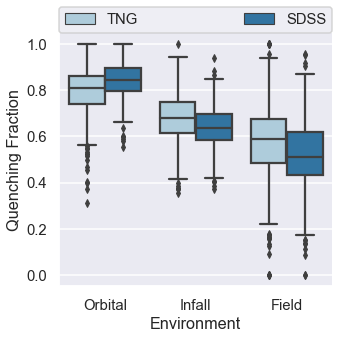

In [80]:
plot_enviroment2(cat1,cat2,'quenching',outname=figure7)

In [50]:
fmts = [['o','-',1.],['s','--',0.6]]

In [51]:
sns.set_style("whitegrid")
sns.set_context("notebook",font_scale=1.0)

In [52]:
colors_dynamics2 = colors_dynamics.copy()
colors_dynamics2[1] = colors_dynamics[2]
colors_dynamics2[2] = colors_dynamics[1]

In [53]:
dataset= 'TNG'
key    = 'volumeLimited'
name   = 'quenching'
xlabel = 'radii'
save   = True

<ipython-input-54-05b104a52e24>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
<ipython-input-54-05b104a52e24>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)


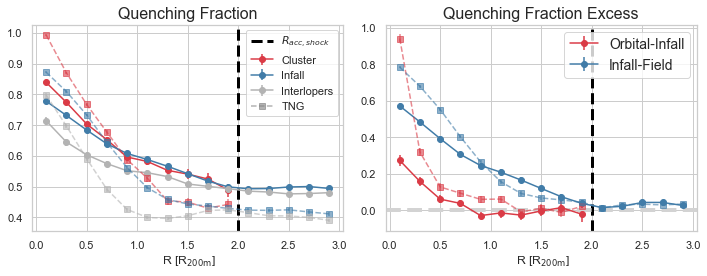

In [54]:
fig = plt.figure(figsize=(10,4))
for kk,dataset in enumerate(['SDSS','TNG']):
    fname = fl.root+f'{dataset}/outputs/{key}/{name}_{xlabel}.npy'
    x = np.loadtxt(fname).T
    plt.subplot(1, 2, 1)
    for i in range(3):
        ii = 4*i + 1
        li = label1[i]
        if kk==1: 
            li = '_'
            if i==0:
                plt.errorbar([None,None],[None,None],alpha=fmts[kk][2],
                             color='gray',ls=fmts[kk][1], fmt=fmts[kk][0],label='TNG')
                
        p = plt.errorbar(x[0][::2], x[ii][::2], yerr=np.vstack([x[ii+1][::2],x[ii+2][::2]]),
                         ls=fmts[kk][1], fmt=fmts[kk][0],alpha=fmts[kk][2],
                         label=li, color=colors_dynamics2[i])
    
    if kk==1:
        plt.axvline(2.,ls='--',lw=3,color='k',label=r'$R_{acc,shock}$')
    # plt.text(2.07, 0.52, 'Field', size=24, color='k')

    plt.legend()
    plt.xlabel(xlabels[xlabel])
    #plt.xlabel(r'Log($M_\star/M_{\odot}$)',fontsize=16)
    plt.title('%s Fraction'%name.capitalize(),fontsize=16)

    plt.subplot(1, 2, 2)
    jj=0
    for i in np.array([0,3]):
        ii = (4*i + 1)+16
        li = label2[i]
        if kk==1: li = '_'
        p = plt.errorbar(x[0][::2], x[ii][::2], yerr=np.vstack([x[ii+1][::2],x[ii+2][::2]]),
                         ls=fmts[kk][1], fmt=fmts[kk][0],alpha=fmts[kk][2],
                         label=li, color=colors_dynamics2[jj])
        jj += 1

plt.axvline(2.,ls='--',lw=3,color='k')
plt.axhline(0.,ls='--',lw=4,color='lightgray')
plt.xlabel(xlabels[xlabel])

plt.legend(fontsize=14)
plt.title('%s Fraction Excess'%name.capitalize(),fontsize=16)

del x
if save:
    save_figures(fig,figure3,is_tight=True)

In [56]:
dataset= 'TNG'
key    = 'volumeLimited'
name   = 'quenching'
xlabel = 'smass'
save   = True

In [57]:
## The magTH has some issues I still don't understand why.

<ipython-input-58-b76f403db0c6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
<ipython-input-58-b76f403db0c6>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)


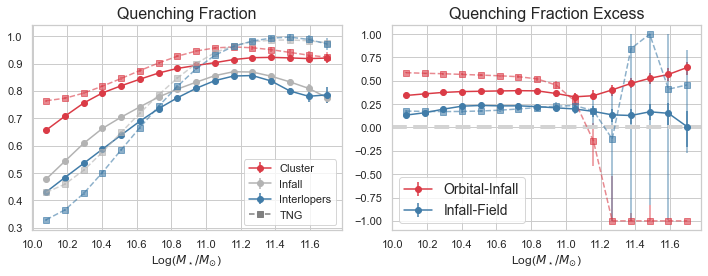

In [58]:
fig = plt.figure(figsize=(10,4))
for kk,dataset in enumerate(['SDSS','TNG']):
    fname = fl.root+f'{dataset}/outputs/{key}/{name}_{xlabel}.npy'

    plt.subplot(1, 2, 1)
    x = np.loadtxt(fname).T
    
    for i in range(3):
        ii = 4*i + 1
        li = label1[i]
        if kk==1: 
            li = '_'
            if i==0:
                plt.errorbar([None,None],[None,None],color='gray',ls=fmts[kk][1], fmt=fmts[kk][0],label='TNG')
        w, = np.where(x[0]>10.05)
        p = plt.errorbar(x[0][w][::2], x[ii][w][::2], yerr=np.vstack([x[ii+1][w][::2],x[ii+2][w][::2]]),
                         ls=fmts[kk][1], fmt=fmts[kk][0],alpha=fmts[kk][2],
                         label=li, color=colors_dynamics[i])
#     plt.axvline(2.,ls='--',lw=3,color='k')
    # plt.text(2.07, 0.52, 'Field', size=24, color='k')

    plt.legend()
    plt.xlabel(xlabels[xlabel])
    #plt.xlabel(r'Log($M_\star/M_{\odot}$)',fontsize=16)
    plt.title('%s Fraction'%name.capitalize(),fontsize=16)

    plt.subplot(1, 2, 2)
    jj=0
    for i in np.array([0,3]):
        ii = (4*i + 1)+16
        li = label2[i]
        if kk==1: li = '_'
        w, = np.where(x[0]>10.05)
        p = plt.errorbar(x[0][w][::2], x[ii][w][::2], yerr=np.vstack([x[ii+1][w][::2],x[ii+2][w][::2]]),
                         ls=fmts[kk][1], fmt=fmts[kk][0],alpha=fmts[kk][2],
                         label=li, color=colors_dynamics2[jj])
        jj += 1

# plt.axvline(2.,ls='--',lw=3,color='k',label=r'$R_{acc,shock}$')
plt.axhline(0.,ls='--',lw=4,color='lightgray')
plt.xlabel(xlabels[xlabel])

plt.legend(fontsize=14)
plt.title('%s Fraction Excess'%name.capitalize(),fontsize=16)

del x
if save:
    save_figures(fig,figureX,is_tight=True)